In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from encoder import *
from AttnDecoder import * 
from seq2seq import *

from build_dataset import *

/ext3/conda/1011_project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load dataloaders 

In [2]:
# load data 
main_data_path = "data/processed"

train_file_path = {
    'source': f"{main_data_path}/src-train.txt",
    'target': f"{main_data_path}/tgt-train.txt"
}

test_file_path = {
    'source': f"{main_data_path}/src-test.txt",
    'target': f"{main_data_path}/tgt-test.txt"
}

dev_file_path = {
    'source': f"{main_data_path}/src-dev.txt",
    'target': f"{main_data_path}/tgt-dev.txt"
}

# build vocab with train data only 
vocab = build_train_vocab(train_file_path)

# build datasets for all train, test, dev
datasets = {
    'train': QAPair(train_file_path, vocab),
    'test': QAPair(test_file_path, vocab),
    'dev': QAPair(dev_file_path, vocab),
}

# build dataloaders
batch_size = 64
dataloaders = {}
for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, pad_token=dataset.pad_idx)
    )

# 2. Load parsed GloVe embeddings

In [3]:
embed_size = 300
pretrained_vectors = {
    'enc': torch.load(f'embeddings/encoder_emb_{embed_size}.pt').float(),
    'dec': torch.load(f'embeddings/decoder_emb_{embed_size}.pt').float()
}

# input_size = len(train_dataset.answer_vocab) 
output_size = len(vocab['target']) 

# 3. Train loop

## 3.1 Define train and eval steps

In [4]:
def train_step(batch, model, optimizer, criterion, device):
    input = batch.input_vecs.to(device) 
    inputs_len = batch.input_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    
    model.train()

    dec_log_probs, dec_hidden = model(input, target, inputs_len, target_len)

    # scores = s2s_output.view(-1, s2s_output.size(-1))
    
    optimizer.zero_grad()
    loss = criterion(dec_log_probs.transpose(1, 2), target)
    loss.backward()
    # clip gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
    
    optimizer.step()

    return loss.item()

def eval_step(batch, model, criterion, device):
    input = batch.input_vecs.to(device) 
    inputs_len = batch.input_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    
    model.eval()

    dec_log_probs, dec_hidden = model(input, target, inputs_len, target_len)

    # scores = s2s_output.view(-1, s2s_output.size(-1))
    
    loss = criterion(dec_log_probs.transpose(1, 2), target)

    return loss.item()
    

## 3.2 Run train loop

In [5]:
from tqdm import tqdm 
# TRAIN LOOP 

lr = 1.0
seq2seq = Seq2Seq(pretrained_vectors, hidden_size=600, output_size=output_size)
optimizer = torch.optim.SGD(seq2seq.parameters(), lr=lr)
criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
device = "cuda" if torch.cuda.is_available() else "cpu"

seq2seq.to(device) 

plot_cache = {}
plot_cache['train'] = []
plot_cache['test'] = []

# halve lr at epoch 8
scheduler = StepLR(optimizer, step_size=8, gamma=0.5) 

NUM_EPOCHS = 15
for epoch in tqdm(range(NUM_EPOCHS)):    
    # train 
    train_losses = []
    for i, data in tqdm(enumerate(dataloaders['train']), leave=False):
        curr_loss = train_step(data, seq2seq, optimizer, criterion, device)

        train_losses.append(curr_loss)
    avg_train_loss = np.mean(train_losses)
    print(f'Train loss after epoch {epoch+1} = {avg_train_loss}')

    # eval 
    val_losses = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
            curr_loss = eval_step(data, seq2seq, criterion, device)

            val_losses.append(curr_loss)

        avg_val_loss = np.mean(val_losses)
        print(f'Val loss after epoch {epoch+1} = {avg_val_loss}')

    plot_cache['train'].append(avg_train_loss)
    plot_cache['test'].append(avg_val_loss)

    scheduler.step()

    


  0%|          | 0/15 [00:00<?, ?it/s]

Train loss after epoch 1 = 3.7525316212873925


  7%|▋         | 1/15 [02:41<37:47, 161.93s/it]

Val loss after epoch 1 = 2.174495138147826


Train loss after epoch 2 = 1.8483454420648773


 13%|█▎        | 2/15 [05:23<35:02, 161.73s/it]

Val loss after epoch 2 = 1.5128041781404966


Train loss after epoch 3 = 1.221986854087203


 20%|██        | 3/15 [08:05<32:20, 161.69s/it]

Val loss after epoch 3 = 0.8320150497139142


Train loss after epoch 4 = 0.8896895104008448


 27%|██▋       | 4/15 [10:48<29:44, 162.24s/it]

Val loss after epoch 4 = 0.6505495402761685


Train loss after epoch 5 = 0.7252577787735068


 33%|███▎      | 5/15 [13:30<27:01, 162.16s/it]

Val loss after epoch 5 = 0.6522797089751049


Train loss after epoch 6 = 0.6215829690225327


 40%|████      | 6/15 [16:12<24:18, 162.02s/it]

Val loss after epoch 6 = 0.4323529702040457


Train loss after epoch 7 = 0.5509799414613502


 47%|████▋     | 7/15 [18:53<21:34, 161.87s/it]

Val loss after epoch 7 = 0.4278197911798313


Train loss after epoch 8 = 0.48694893006512563


 53%|█████▎    | 8/15 [21:34<18:51, 161.64s/it]

Val loss after epoch 8 = 0.3462603886121063


Train loss after epoch 9 = 0.43281849247898685


 60%|██████    | 9/15 [24:16<16:09, 161.63s/it]

Val loss after epoch 9 = 0.3042786013214819


Train loss after epoch 10 = 0.4115820230676128


 67%|██████▋   | 10/15 [26:58<13:28, 161.79s/it]

Val loss after epoch 10 = 0.2980217980921909


Train loss after epoch 11 = 0.39300524414991944


 73%|███████▎  | 11/15 [29:40<10:46, 161.71s/it]

Val loss after epoch 11 = 0.28615723750604094


Train loss after epoch 12 = 0.3766765268198375


 80%|████████  | 12/15 [32:21<08:05, 161.77s/it]

Val loss after epoch 12 = 0.307850327222578


Train loss after epoch 13 = 0.36137366841146606


 87%|████████▋ | 13/15 [35:03<05:23, 161.57s/it]

Val loss after epoch 13 = 0.24873533636652012


Train loss after epoch 14 = 0.3475229986782732


 93%|█████████▎| 14/15 [37:44<02:41, 161.43s/it]

Val loss after epoch 14 = 0.24289014647083898


Train loss after epoch 15 = 0.3342716912122041


100%|██████████| 15/15 [40:27<00:00, 161.84s/it]

Val loss after epoch 15 = 0.22854755626570794


In [6]:
# PLOT TRAIN AND VAL LOSS
import matplotlib.pyplot as plt 
def plot_over_training(per_epoch_metrics, title_name, num_epochs):
    t = np.arange(1, num_epochs+1)

    fig, ax1 = plt.subplots()

    colors = ['tab:blue', 'tab:red']
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    for key, color in zip(per_epoch_metrics, colors):
        label = f'{key}_loss'
        ax1.plot(t, per_epoch_metrics[key], color=color, linewidth=1, label=label)

    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')

    fig.tight_layout
    plt.title(title_name)
    plt.show()


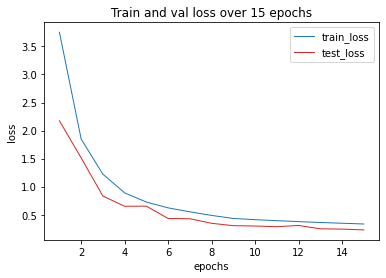

In [7]:
plot_over_training(plot_cache, 'Train and val loss over 15 epochs', 15)